# Vectorisation Bag of Words (BoW) avec CountVectorizer et classification avec Perceptron

In [1]:
from common.text_classification_utils import *

dataset = load_dataset()

dataset

,text,CORRECT,NOT_FRENCH,NOT_TRIP,UNKNOWN
0,zrkrwmgseetfegaozv kovx vh,0,0,0,1
1,Comment puis-je me rendre de l'aéroport de CHA...,1,0,0,0
2,4f3;S0`HsL# hL8ydlwlM2cK7=,0,0,0,1
3,"u*]P\UsbAr,CoDnDdr*-GKN(0O",0,0,0,1
4,J'aimerais connaître le chemin pour aller de S...,1,0,0,0
...,...,...,...,...,...
1302960,Il a prétendu être mon ami.,0,0,1,0
1302961,I am planning a trip from saint paul les dax t...,0,1,0,0
1302962,Go from the train station of Loches to Venarey...,0,1,0,0
1302963,Je souhaiterais aller à verneuil sur serre dep...,1,0,0,0


In [2]:
labels, id2label, label2id = prepare_labels(dataset)

['CORRECT', 'NOT_FRENCH', 'NOT_TRIP', 'UNKNOWN']


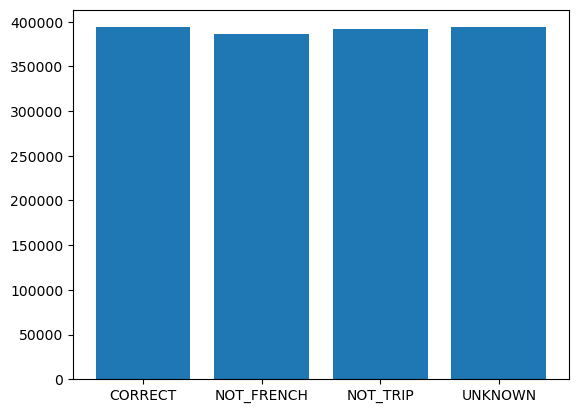

In [3]:
show_labels_distribution(dataset, labels)

# Split du dataset en train, test et validation

In [4]:
X_train, X_test, X_val, y_train, y_test, y_val = split_dataset(dataset, labels, final_dataset_size=0.1)

In [5]:
X_train.values

array(['X\\5aKOXBCud8tLr#"gUwLpo\\U#',
       'He took advantage of the good weather to do some gardening.',
       'Comment aller à la gare de chauffailles ?', ...,
       "Montre-moi le chemin pour passer de la place centrale de Sisteron à la place centrale de Urcay-Hotel-Du-Lyon-D'O.",
       "L'arrivée à BEAUVOIR-SUR-NIORT est prévue.",
       'I want to arrive at Bordeaux.'], dtype=object)

La plupart des features extraites sont des mots issus de la classe UNKNOWN générés aléatoirement mais qui apparaissent très peu de fois 

# Utilisation d'un pipeline SKLearn (vectorizer + classifier LogisticRegression avec OneVsRestClassifier pour la classification multi-label)

In [6]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import Perceptron

pipeline = create_pipeline(
    CountVectorizer(ngram_range=(1, 2)),
    CalibratedClassifierCV(Perceptron()),
)

pipeline.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', CountVectorizer(ngram_range=(1, 2))),
                ('classifier',
                 OneVsRestClassifier(estimator=CalibratedClassifierCV(estimator=Perceptron())))])

# Evaluation du modèle, métriques

In [7]:
y_pred = pipeline.predict(X_test)

show_classification_report(y_pred, y_test, labels)

Classification Report for 
              precision    recall  f1-score   support

     CORRECT       1.00      1.00      1.00     20303
  NOT_FRENCH       1.00      0.88      0.94     19628
    NOT_TRIP       1.00      0.84      0.91     20026
     UNKNOWN       0.99      1.00      0.99     20419

   micro avg       1.00      0.93      0.96     80376
   macro avg       1.00      0.93      0.96     80376
weighted avg       1.00      0.93      0.96     80376
 samples avg       0.97      0.95      0.96     80376


C:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### On observe ici que le modèle semble performant, excepté au niveau du recall pour les classes NOT_FRENCH et NOT_TRIP

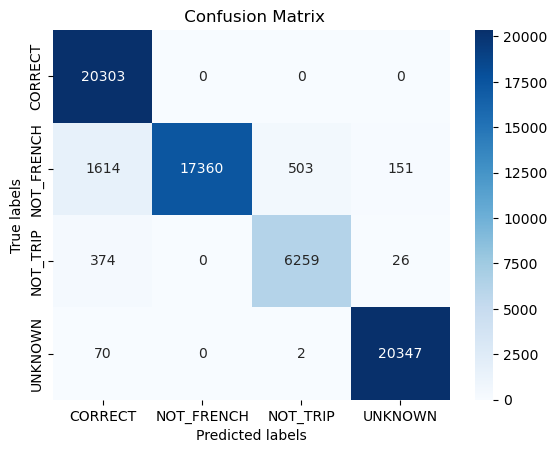

In [8]:
show_confusion_matrix(y_pred, y_test, labels)

### La tendance se confirme pour ces deux labels au vu du manquement autour des vrais positifs

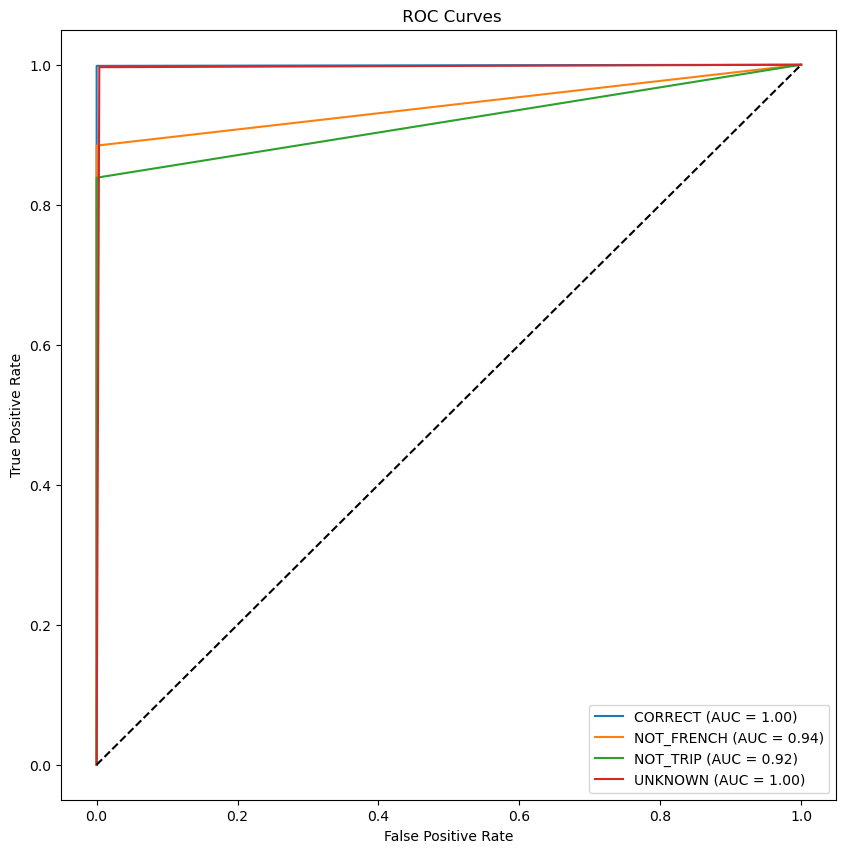

In [9]:
show_roc_curves(labels, y_pred, y_test)

In [10]:
show_samples_predictions(pipeline, id2label)

* Je veux aller de Port-Boulet à Le Havre.
 - CORRECT => 87.5%
 - NOT_FRENCH => 1.4%
 - NOT_TRIP => 14.0%
 - UNKNOWN => 0.0%

* Je veux aller de Port-Boulet au Havre.
 - CORRECT => 71.7%
 - NOT_FRENCH => 1.0%
 - NOT_TRIP => 13.0%
 - UNKNOWN => 0.0%

* Je vais de Nantes à Paris.
 - CORRECT => 87.0%
 - NOT_FRENCH => 3.9%
 - NOT_TRIP => 20.7%
 - UNKNOWN => 0.0%

* Je vais de Nantes à Nantes.
 - CORRECT => 90.2%
 - NOT_FRENCH => 3.5%
 - NOT_TRIP => 17.1%
 - UNKNOWN => 0.0%

* Je veux aller de Nantes à Nantes.
 - CORRECT => 98.2%
 - NOT_FRENCH => 1.4%
 - NOT_TRIP => 10.8%
 - UNKNOWN => 0.0%

* Je vais à Port-Boulet en partant de Le Havre
 - CORRECT => 99.7%
 - NOT_FRENCH => 0.6%
 - NOT_TRIP => 9.8%
 - UNKNOWN => 0.0%

* Je vais à Port-Boulet en partant du Havre
 - CORRECT => 94.0%
 - NOT_FRENCH => 2.2%
 - NOT_TRIP => 12.8%
 - UNKNOWN => 0.0%

* Peux-tu m'aider à trouver mon chemin vers Paris en partant d'Épierre ?
 - CORRECT => 100.0%
 - NOT_FRENCH => 0.2%
 - NOT_TRIP => 5.8%
 - UNKNOWN => 

### Le classifier semble avoir de bonnes performances, excepté pour classer des phrases contenant la même arrivée/départ en tant qu'UNKNOWN. 